In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import time
import random
from datetime import datetime, timedelta

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment & Reddit
import praw
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Market & Trends
import yfinance as yf
from pytrends.request import TrendReq

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Download VADER lexicon
#nltk.download('vader_lexicon')

In [2]:
#!pip install vaderSentiment

In [3]:
reddit = praw.Reddit(
    client_id='hqyGoj8LWOr_uc4QKJp1jg',
    client_secret='WhjtBRaAabetZ0bsLgKlTH4JMJnC8A',
    user_agent='TraderBot'
)

# ----------------------------------
# 1. Reddit Sentiment Collection (Last 7 Days)
# ----------------------------------

import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Setup subreddits and API
subreddits = ['stocks', 'wallstreetbets', 'investing', 'smallstreetbets', 'growthstocks', 'stockmarket', 'daytrading', 'options', 'cryptocurrency']
post_limit = 1000
analyzer = SentimentIntensityAnalyzer()

def extract_tickers(text):
    return re.findall(r'\$[A-Z]{1,5}', text)

def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Collect posts from the last 7 days only
min_time = datetime.utcnow() - timedelta(days=7)
posts = []

for sub in subreddits:
    print(f"🔍 Fetching r/{sub}")
    for post in reddit.subreddit(sub).top(time_filter='month', limit=1000):
        post_time = datetime.utcfromtimestamp(post.created_utc)
        tickers = extract_tickers(post.title)
        if tickers:
            sentiment = get_sentiment(post.title)
            for ticker in tickers:
                posts.append({
                    'date': post_time.date(),
                    'subreddit': sub,
                    'tickers': ticker.replace('$', ''),
                    'title': post.title,
                    'sentiment_score': sentiment,
                    'score': post.score,
                    'num_comments': post.num_comments
                })
    time.sleep(1)



# Create DataFrame
df = pd.DataFrame(posts)
df = df[df['sentiment_score'] != 0.0]
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'bullish' if x > 0 else 'bearish')
df['mention_count'] = df.groupby('tickers')['tickers'].transform('count')

# Save
df.to_csv('/tmp/reddit_sentiment_daily.csv', index=False)
print("✅ Saved sentiment data from the last 7 days.")

df.head()

/var/folders/lw/v307b3qn5ll1nrw1fdpf8gkh0000gn/T/ipykernel_73265/139657106.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  min_time = datetime.utcnow() - timedelta(days=7)


🔍 Fetching r/stocks


/var/folders/lw/v307b3qn5ll1nrw1fdpf8gkh0000gn/T/ipykernel_73265/139657106.py:36: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_time = datetime.utcfromtimestamp(post.created_utc)


🔍 Fetching r/wallstreetbets
🔍 Fetching r/investing
🔍 Fetching r/pennystocks
🔍 Fetching r/smallstreetbets
🔍 Fetching r/growthstocks
🔍 Fetching r/stockmarket
🔍 Fetching r/daytrading
🔍 Fetching r/options
🔍 Fetching r/cryptocurrency
✅ Saved sentiment data from the last 7 days.


,date,subreddit,tickers,title,sentiment_score,score,num_comments,sentiment_label,mention_count
0,2025-06-06,stocks,TSLA,Musk Blinks First in $34B Tesla Meltdown Amid ...,-0.3400,916,399,bearish,5
5,2025-06-02,stocks,COKE,Ia now a good time to buy Coke consolidated? $...,0.4404,80,63,bullish,1
7,2025-05-21,stocks,FICO,Fair Issac $FICO down 25% in two days over FHF...,0.5994,27,9,bullish,1
8,2025-05-09,stocks,NET,"$NET pops over 10% on revenue beat, slight ear...",-0.0828,26,5,bearish,1
11,2025-05-08,stocks,ZIM,$ZIM looking weak,-0.4404,10,3,bearish,1


In [4]:
import pandas as pd

df = pd.read_csv('/tmp/reddit_sentiment_daily.csv')
df['date'] = pd.to_datetime(df['date'])

# Count how many unique dates each ticker appears in
ticker_date_counts = df.groupby('tickers')['date'].nunique().sort_values(ascending=False)

print("📊 Number of days each ticker has sentiment data:\n")
print(ticker_date_counts.head(20))  # top 20 tickers


📊 Number of days each ticker has sentiment data:

tickers
UNH      9
SPY      5
GOOG     5
BURU     4
TSLA     3
ILLR     3
AVGO     3
NGCG     3
PLTR     3
BULL     2
LITM     2
WHITE    2
HOOD     2
WRD      2
NVDA     2
BTC      2
PPC      1
PY       1
PYPD     1
OM       1
Name: date, dtype: int64


In [5]:
# ----------------------------------
# 2. Google Trends Fetching
# ----------------------------------

from pytrends.request import TrendReq

reddit_df = pd.read_csv('/tmp/reddit_sentiment_daily.csv')
top_tickers = reddit_df['tickers'].value_counts().head(30).index.tolist()
pytrends = TrendReq(hl='en-US', tz=360, timeout=(10, 25))
trend_list = []

for i in range(0, len(top_tickers), 5):
    batch = top_tickers[i:i+5]
    tries = 0
    success = False

    while not success and tries < 3:
        try:
            pytrends.build_payload(batch, timeframe='now 7-d')
            df_batch = pytrends.interest_over_time()
            if df_batch.empty:
                break
            df_batch = df_batch.reset_index().drop(columns=['isPartial'], errors='ignore')
            df_avg = df_batch[batch].mean().reset_index()
            df_avg.columns = ['tickers', 'google_trend']
            trend_list.append(df_avg)
            time.sleep(random.uniform(8, 12))
            success = True
        except Exception:
            tries += 1
            time.sleep(20 * tries)

trend_df = pd.concat(trend_list)

trend_df.head()

,tickers,google_trend
0,UNH,2.159763
1,WRD,0.378698
2,TSLA,11.236686
3,GOOG,4.715976
4,SPY,17.514793


In [6]:
import yfinance as yf

# Reload base Reddit sentiment data
df = pd.read_csv('/tmp/reddit_sentiment_daily.csv')
df['mention_count'] = df.groupby('tickers')['tickers'].transform('count')
df = df.merge(trend_df, on='tickers', how='left')

# Get tickers
tickers = df['tickers'].unique().tolist()
price_data = yf.download(tickers, period="7d", interval="1d", group_by='ticker', threads=True, auto_adjust=True)

# Calculate price movement
price_labels = []
failed_tickers = []

for ticker in tickers:
    try:
        ticker_data = price_data[ticker]
        open_price = ticker_data['Open'].iloc[0]
        close_price = ticker_data['Close'].iloc[-1]

        if pd.isna(open_price) or pd.isna(close_price):
            raise ValueError("Missing price data")

        change_pct = ((close_price - open_price) / open_price) * 100

        if change_pct > 2:
            label = 1
        elif change_pct < -2:
            label = 0
        else:
            label = None

        price_labels.append({'tickers': ticker, 'price_movement_label': label})

    except Exception as e:
        failed_tickers.append(ticker)
        continue

# Report excluded tickers
print(f"❌ Excluded tickers due to missing data: {failed_tickers}")

# Keep only valid tickers
price_df = pd.DataFrame(price_labels)
df = df[df['tickers'].isin(price_df['tickers'])]
df = df.merge(price_df, on='tickers', how='left')
df = df.dropna(subset=['price_movement_label'])

df.head()


[*********************100%***********************]  128 of 128 completed

9 Failed downloads:
['SUPR', 'WFLD', 'JWN']: YFPricesMissingError('possibly delisted; no price data found  (period=7d)')
['JANXI']: HTTPError('HTTP Error 404: ')
['QIMC', 'SPTZ', 'MILI', 'WHITE', 'TRUMP']: YFPricesMissingError('possibly delisted; no price data found  (period=7d) (Yahoo error = "No data found, symbol may be delisted")')


❌ Excluded tickers due to missing data: ['JANXI', 'MILI', 'SPTZ', 'QIMC', 'WFLD', 'WHITE', 'SUPR', 'JWN', 'TRUMP']


,date,subreddit,tickers,title,sentiment_score,score,num_comments,sentiment_label,mention_count,google_trend,price_movement_label
0,2025-06-06,stocks,TSLA,Musk Blinks First in $34B Tesla Meltdown Amid ...,-0.3400,916,399,bearish,5,11.236686,0.0
1,2025-06-02,stocks,COKE,Ia now a good time to buy Coke consolidated? $...,0.4404,80,63,bullish,1,NaN,0.0
2,2025-05-21,stocks,FICO,Fair Issac $FICO down 25% in two days over FHF...,0.5994,27,9,bullish,1,NaN,1.0
3,2025-05-09,stocks,NET,"$NET pops over 10% on revenue beat, slight ear...",-0.0828,26,5,bearish,1,NaN,1.0
5,2025-05-19,stocks,ALB,Would love to hear opinions on $ALB Albermarle,0.6369,4,22,bullish,1,NaN,1.0


In [7]:
# ----------------------------------
# 4. Feature Engineering
# ----------------------------------

df['sentiment_strength'] = df['sentiment_score'] * df['mention_count']
df['sentiment_abs'] = df['sentiment_score'].abs()

X = df[['sentiment_score', 'mention_count', 'google_trend', 'sentiment_strength', 'sentiment_abs']]
y = df['price_movement_label']

    tickers  confidence  sentiment_score  mention_count
26      UNH    0.980058           0.2732             10
13      UNH    0.970825           0.2960             10
88     BURU    0.957810           0.7783              4
12      UNH    0.933852          -0.7650             10
162     UNH    0.920637           0.8519             10
45     RXRX    0.883890           0.2732              1
154    ASST    0.883890           0.2960              1
134    NUGT    0.765521           0.5423              1
66      MSW    0.765521           0.5574              1
119    ILLR    0.706360          -0.1491              3

📊 Accuracy: 76.92%
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         8
         1.0       0.88      0.78      0.82        18

    accuracy                           0.77        26
   macro avg       0.74      0.76      0.75        26
weighted avg       0.79      0.77      0.78        26



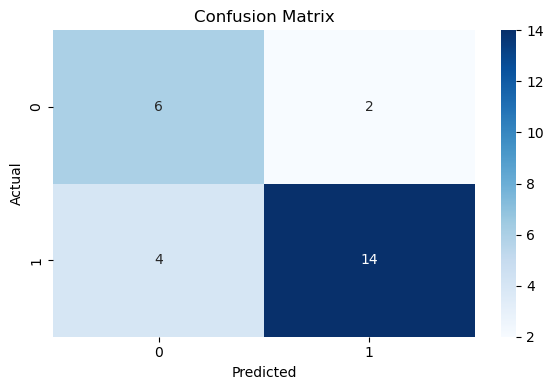

In [8]:
# ----------------------------------
# 5. Modeling with XGBoost
# ----------------------------------

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

results = X_test.copy()
results['actual'] = y_test
results['predicted'] = y_pred
results['confidence'] = y_prob
results['tickers'] = df.loc[X_test.index, 'tickers'].values

high_confidence = results[(results['predicted'] == 1) & (results['confidence'] > 0.7)]
top_signals = high_confidence.sort_values(by='confidence', ascending=False)
print(top_signals[['tickers', 'confidence', 'sentiment_score', 'mention_count']].head(10))

top_signals.to_csv('/tmp/high_confidence_signals.csv', index=False)

print(f"\n📊 Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

/var/folders/lw/v307b3qn5ll1nrw1fdpf8gkh0000gn/T/ipykernel_73265/1622022218.py:10: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


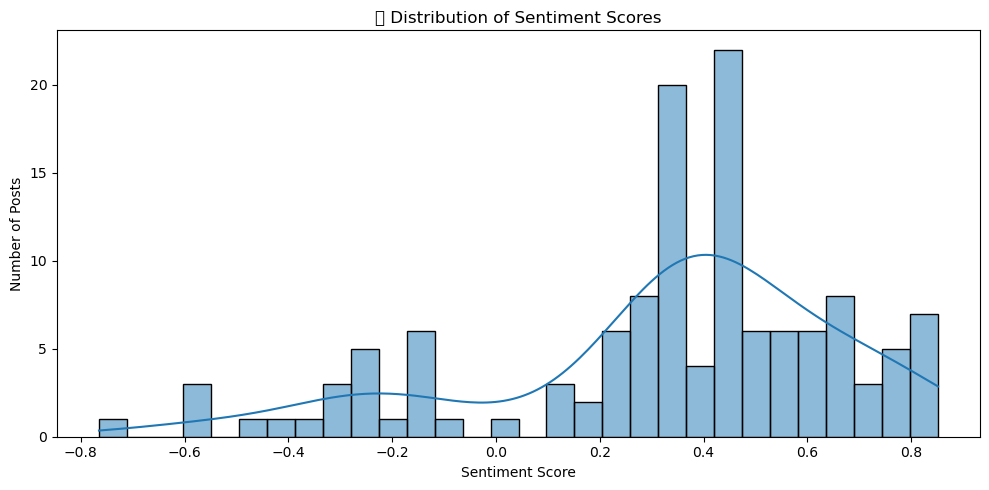

In [9]:
# ----------------------------------------
# 2. Sentiment Score Distribution
# ----------------------------------------

plt.figure(figsize=(10, 5))
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title("🧠 Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

📈 Top 10 Bullish Tickers on Reddit:
 tickers
CETY    0.836000
LULU    0.815100
SURG    0.812600
EVAX    0.807400
NBIS    0.788200
BURU    0.779325
ILLR    0.778300
RIME    0.778300
FNMA    0.749400
CRWV    0.718400
Name: sentiment_score, dtype: float64

📉 Top 10 Bearish Tickers on Reddit:
 tickers
UNH    -0.636267
HTZ    -0.571900
CVNA   -0.474000
ACTU   -0.401900
TSLA   -0.340000
CISO   -0.318200
PYPD   -0.318200
RIG    -0.303400
AUUD   -0.273200
IBIO   -0.273200
Name: sentiment_score, dtype: float64

📊 Ticker Mention Volume and Sentiment:
         sentiment_score      
                   mean count
tickers                      
UNH            0.095160    10
WRD            0.537737     8
TSLA           0.228320     5
BURU           0.779325     4
ILLR           0.167067     3
NGCG           0.252567     3
LITM           0.473550     2
KSS            0.280750     2
HOOD           0.383900     2
JANX           0.571900     2


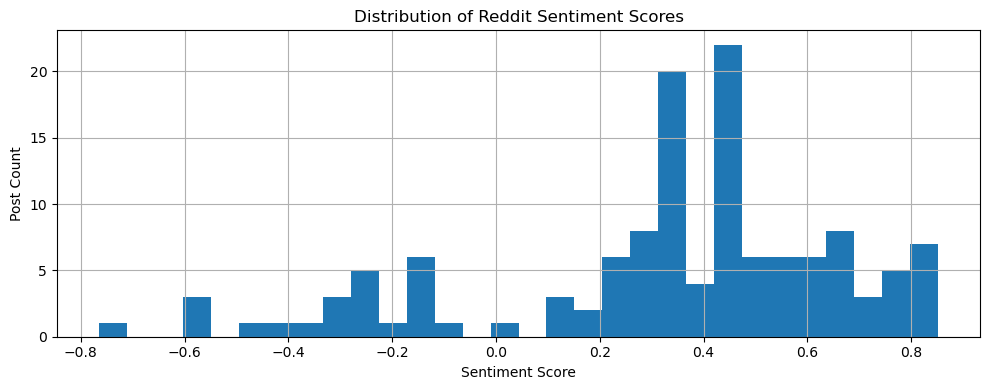

In [10]:
# --------------------------------------------
# 2. Sentiment Visualization
# --------------------------------------------

import seaborn as sns

# Top Bullish and Bearish
bullish = df[df['sentiment_label'] == 'bullish'].groupby('tickers')['sentiment_score'].mean().sort_values(ascending=False)
bearish = df[df['sentiment_label'] == 'bearish'].groupby('tickers')['sentiment_score'].mean().sort_values()

print("📈 Top 10 Bullish Tickers on Reddit:\n", bullish.head(10))
print("\n📉 Top 10 Bearish Tickers on Reddit:\n", bearish.head(10))

# Mention Volume
mention_stats = df.groupby('tickers').agg({'sentiment_score': ['mean', 'count']}).sort_values(('sentiment_score', 'count'), ascending=False)
print("\n📊 Ticker Mention Volume and Sentiment:\n", mention_stats.head(10))

# Sentiment Distribution
plt.figure(figsize=(10, 4))
df['sentiment_score'].hist(bins=30)
plt.title("Distribution of Reddit Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Post Count")
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Plotting for UNH


[*********************100%***********************]  1 of 1 completed


❌ Google Trends error for UNH: The request failed: Google returned a response with code 429


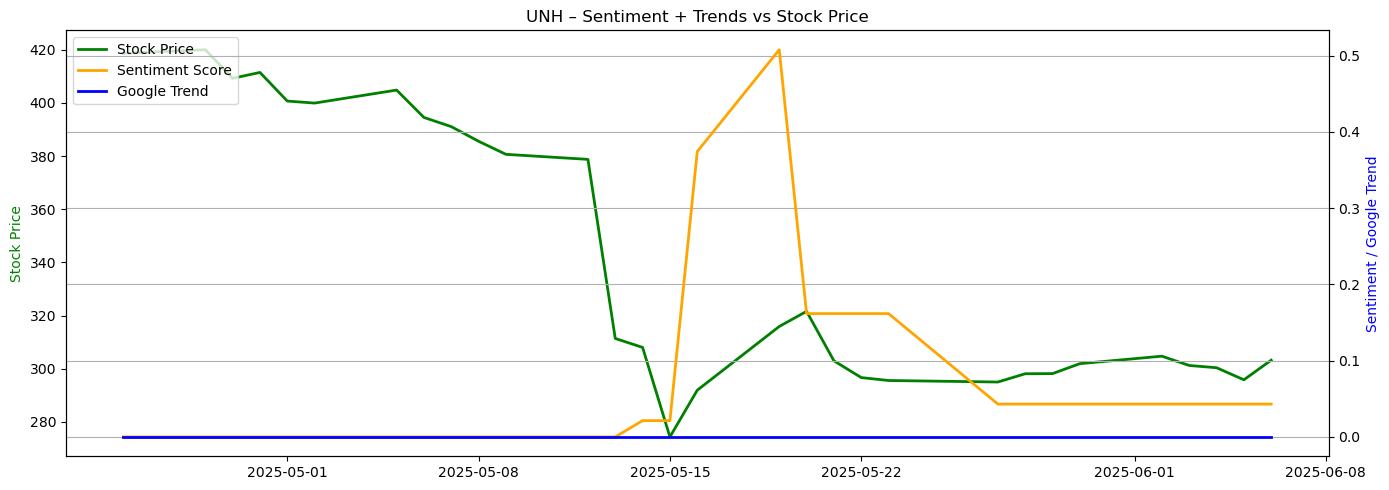

📊 Plotting for EVAX


[*********************100%***********************]  1 of 1 completed


❌ Google Trends error for EVAX: The request failed: Google returned a response with code 429


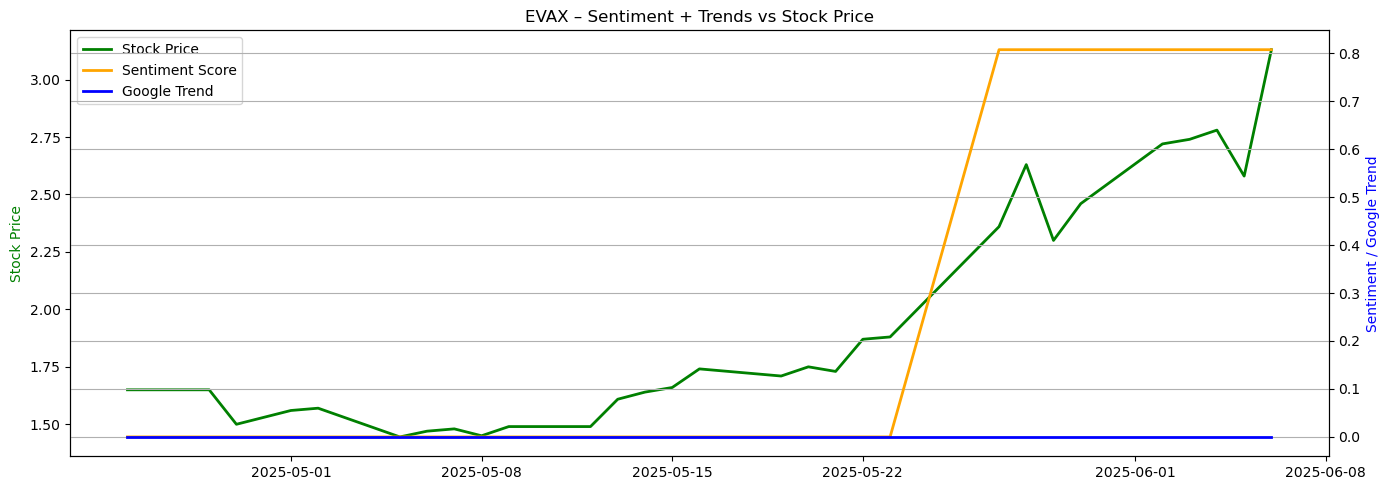

📊 Plotting for NVDA


[*********************100%***********************]  1 of 1 completed


❌ Google Trends error for NVDA: The request failed: Google returned a response with code 429


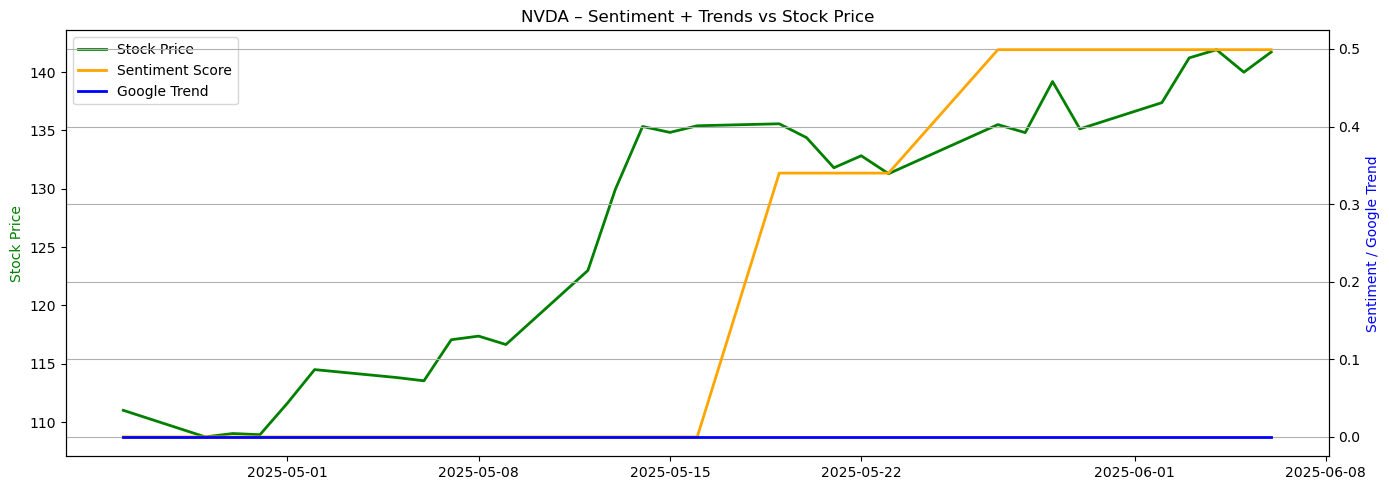

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pytrends.request import TrendReq

# Load Reddit sentiment data
df = pd.read_csv('/tmp/reddit_sentiment_daily.csv')
df['date'] = pd.to_datetime(df['date'])

# Set up Google Trends
pytrends = TrendReq(hl='en-US', tz=360)
selected_tickers = ['UNH', 'EVAX', 'NVDA']

for ticker in selected_tickers:
    print(f"📊 Plotting for {ticker}")

    # --- 1. Stock Price ---
    price_df = yf.download(ticker, period='30d', interval='1d')[['Close']].reset_index()
    price_df.columns = ['date', 'price']
    price_df['date'] = pd.to_datetime(price_df['date'])

    # --- 2. Reddit Sentiment ---
    sentiment_df = df[df['tickers'] == ticker].copy()
    sentiment_df['sentiment_score'] = sentiment_df['sentiment_score'].rolling(window=3, min_periods=1).mean()
    sentiment_df = sentiment_df.groupby('date')['sentiment_score'].mean().reset_index()

    # --- 3. Google Trends ---
    try:
        pytrends.build_payload([ticker], timeframe='today 1-m')
        trend_df = pytrends.interest_over_time().reset_index()
        trend_df = trend_df.rename(columns={ticker: 'google_trend'})
        trend_df = trend_df[['date', 'google_trend']]
        trend_df['date'] = pd.to_datetime(trend_df['date'])
    except Exception as e:
        print(f"❌ Google Trends error for {ticker}: {e}")
        trend_df = pd.DataFrame(columns=['date', 'google_trend'])

    # --- Merge all ---
    merged = pd.merge(price_df, sentiment_df, on='date', how='left')
    merged = pd.merge(merged, trend_df, on='date', how='left')

    # Fill gaps
    merged['sentiment_score'] = merged['sentiment_score'].fillna(method='ffill').fillna(0)
    merged['google_trend'] = merged['google_trend'].fillna(method='ffill').fillna(0)

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.set_title(f"{ticker} – Sentiment + Trends vs Stock Price")
    ax1.plot(merged['date'], merged['price'], color='green', label='Stock Price', linewidth=2)
    ax1.set_ylabel('Stock Price', color='green')

    ax2 = ax1.twinx()
    ax2.plot(merged['date'], merged['sentiment_score'], color='orange', label='Sentiment Score', linewidth=2)
    ax2.plot(merged['date'], merged['google_trend'], color='blue', label='Google Trend', linewidth=2)
    ax2.set_ylabel('Sentiment / Google Trend', color='blue')

    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.grid(True)
    plt.tight_layout()
    plt.show()
